Proszę wgrać plik 'cases_clinical_for_lab12.csv' używając przycisku poniżej:


Saving cases_clinical_for_lab12.csv to cases_clinical_for_lab12 (1).csv
Wczytano plik: cases_clinical_for_lab12 (1).csv

--- Przetwarzanie danych ---

--- Wyniki szczegółowe dla progów ---

Próg: 0.4 | Accuracy: 0.68
Błędy -> Przeoczenia (FN): 17, Fałszywe alarmy (FP): 80

Próg: 0.5 | Accuracy: 0.72
Błędy -> Przeoczenia (FN): 24, Fałszywe alarmy (FP): 60

Próg: 0.6 | Accuracy: 0.76
Błędy -> Przeoczenia (FN): 37, Fałszywe alarmy (FP): 35


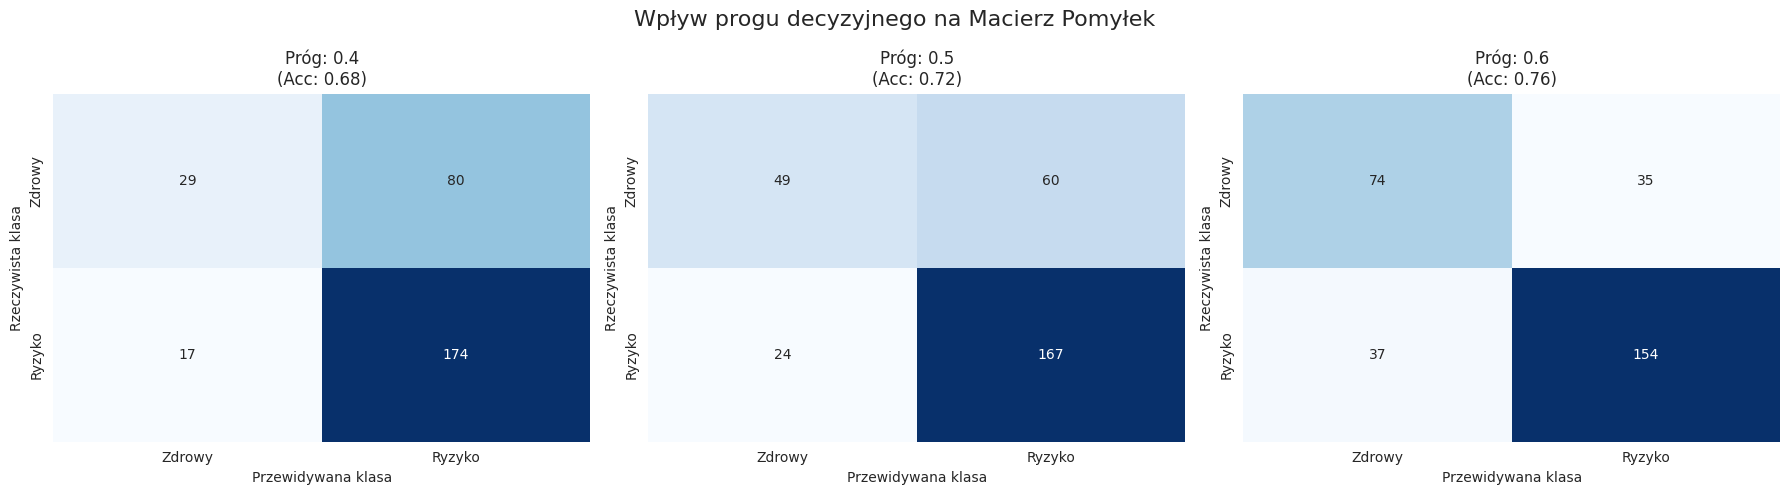

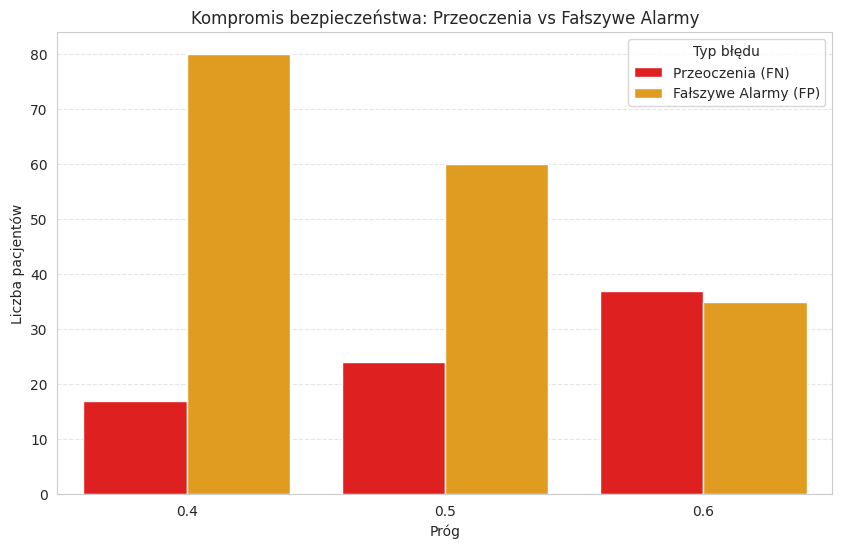

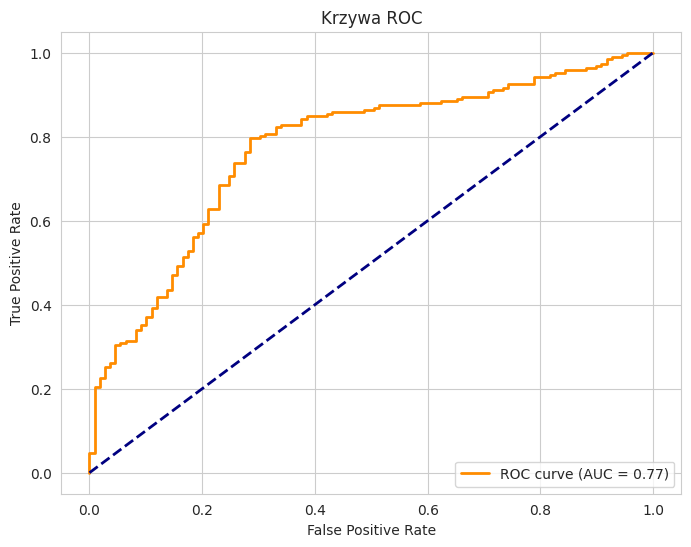


=== Analiza Przypadków Błędnych (Próg 0.5) ===

1. FALSE NEGATIVES (Pacjent chory, model uznał za zdrowego) - Znaleziono: 24


,sex,age,bmi,systolic_bp,diastolic_bp,glucose,smoker,family_history,high_risk_cvd,Predykcja_Modelu,Rzeczywistosc
740,0,31.0,22.700000,119.0,72.0,100.488347,0,0,1,0,1
411,1,21.0,25.794894,117.0,69.0,103.000000,0,0,1,0,1
883,0,21.0,24.200000,144.0,76.0,60.000000,0,0,1,0,1



2. FALSE POSITIVES (Pacjent zdrowy, model uznał za chorego) - Znaleziono: 60


,sex,age,bmi,systolic_bp,diastolic_bp,glucose,smoker,family_history,high_risk_cvd,Predykcja_Modelu,Rzeczywistosc
521,0,21.0,22.3,157.0,79.0,100.488347,1,0,0,1,0
76,0,51.0,29.8,116.0,94.0,81.000000,0,0,0,1,0
636,1,42.0,30.1,155.0,89.0,125.000000,0,0,0,1,0


In [2]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Ustawienia wykresów
sns.set_style("whitegrid")

# ==========================================
# KROK 1: Wgranie pliku
# ==========================================
print("Proszę wgrać plik 'cases_clinical_for_lab12.csv' używając przycisku poniżej:")
uploaded = files.upload()

if uploaded:
    filename = next(iter(uploaded))
    print(f"Wczytano plik: {filename}")
    df = pd.read_csv(io.BytesIO(uploaded[filename]))

    # ==========================================
    # KROK 2: Preprocessing
    # ==========================================
    print("\n--- Przetwarzanie danych ---")

    # Definicja kolumn
    num_cols = ['age', 'bmi', 'systolic_bp', 'diastolic_bp', 'glucose']
    cat_cols = ['sex', 'smoker', 'family_history']
    target = 'high_risk_cvd'

    # Sprawdzenie kolumn
    if all(c in df.columns for c in num_cols + cat_cols + [target]):
        # Imputacja
        imputer_num = SimpleImputer(strategy='mean')
        imputer_cat = SimpleImputer(strategy='most_frequent')

        df[num_cols] = imputer_num.fit_transform(df[num_cols])
        df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

        # Kodowanie
        le = LabelEncoder()
        for col in cat_cols:
            df[col] = le.fit_transform(df[col])

        # Podział
        X = df.drop(target, axis=1)
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Skalowanie
        scaler = StandardScaler()
        X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
        X_test[num_cols] = scaler.transform(X_test[num_cols])

        # ==========================================
        # KROK 3: Modelowanie
        # ==========================================
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

        # ==========================================
        # KROK 4: Ewaluacja i Wykresy
        # ==========================================
        thresholds = [0.4, 0.5, 0.6]
        metrics_data = [] # Lista do zbierania danych na wykres słupkowy

        # Przygotowanie obszaru na wykresy macierzy (3 obok siebie)
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Wpływ progu decyzyjnego na Macierz Pomyłek', fontsize=16)

        print("\n--- Wyniki szczegółowe dla progów ---")

        for i, t in enumerate(thresholds):
            y_pred_t = (y_proba >= t).astype(int)
            cm = confusion_matrix(y_test, y_pred_t)
            acc = accuracy_score(y_test, y_pred_t)
            tn, fp, fn, tp = cm.ravel()

            # Wypisanie tekstu
            print(f"\nPróg: {t} | Accuracy: {acc:.2f}")
            print(f"Błędy -> Przeoczenia (FN): {fn}, Fałszywe alarmy (FP): {fp}")

            # Zbieranie danych do wykresu
            metrics_data.append({
                'Próg': str(t),
                'Przeoczenia (FN)': fn,
                'Fałszywe Alarmy (FP)': fp
            })

            # Rysowanie heatmapy
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
            axes[i].set_title(f'Próg: {t}\n(Acc: {acc:.2f})')
            axes[i].set_xlabel('Przewidywana klasa')
            axes[i].set_ylabel('Rzeczywista klasa')
            axes[i].set_xticklabels(['Zdrowy', 'Ryzyko'])
            axes[i].set_yticklabels(['Zdrowy', 'Ryzyko'])

        plt.tight_layout()
        plt.show()

        # --- Wykres 2: Kompromis błędów ---
        metrics_df = pd.DataFrame(metrics_data)
        metrics_melted = metrics_df.melt(id_vars='Próg', var_name='Typ błędu', value_name='Liczba')

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Próg', y='Liczba', hue='Typ błędu', data=metrics_melted, palette=['red', 'orange'])
        plt.title('Kompromis bezpieczeństwa: Przeoczenia vs Fałszywe Alarmy')
        plt.ylabel('Liczba pacjentów')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()

        # --- Wykres 3: Krzywa ROC ---
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Krzywa ROC')
        plt.legend(loc="lower right")
        plt.show()

        # ==========================================
        # KROK 5: Analiza Przypadków (Tekstowa)
        # ==========================================
        t_analysis = 0.5
        y_pred_analysis = (y_proba >= t_analysis).astype(int)

        # Pobieramy oryginalne dane (przed skalowaniem) dla czytelności
        # Uwaga: używamy indeksów z X_test
        df_display = df.loc[X_test.index].copy()
        df_display['Predykcja_Modelu'] = y_pred_analysis
        df_display['Rzeczywistosc'] = y_test

        fn_cases = df_display[(df_display['Rzeczywistosc'] == 1) & (df_display['Predykcja_Modelu'] == 0)]
        fp_cases = df_display[(df_display['Rzeczywistosc'] == 0) & (df_display['Predykcja_Modelu'] == 1)]

        print("\n=== Analiza Przypadków Błędnych (Próg 0.5) ===")
        print(f"\n1. FALSE NEGATIVES (Pacjent chory, model uznał za zdrowego) - Znaleziono: {len(fn_cases)}")
        if not fn_cases.empty:
            display(fn_cases.head(3))

        print(f"\n2. FALSE POSITIVES (Pacjent zdrowy, model uznał za chorego) - Znaleziono: {len(fp_cases)}")
        if not fp_cases.empty:
            display(fp_cases.head(3))

    else:
        print(f"Błąd: Brakuje wymaganych kolumn w pliku. Oczekiwane: {num_cols + cat_cols + [target]}")
else:
    print("Nie wgrano pliku.")